In [1]:
!git clone https://github.com/harritaylor/torchvggish.git

Cloning into 'torchvggish'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 209 (delta 29), reused 24 (delta 24), pack-reused 172
Receiving objects: 100% (209/209), 328.85 KiB | 4.91 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [49]:
!nvidia-smi

Wed Apr 24 16:17:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:AF:00.0 Off |                    0 |
| N/A   68C    P0              33W /  70W |    934MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [48]:
%pip install -r requirement.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Using cached fastrlock-0.8.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl.metadata (9.3 kB)
Using cached fastrlock-0.8.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl (52 kB)
anceled
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


## Download the data
skip if already done

In [18]:
import os
import sys

import pandas as pd
import numpy as np
import s3fs
import zipfile
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [19]:
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [20]:
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [21]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LV.zip')

[None]

In [22]:
# Décompresser les données
with zipfile.ZipFile("data/LV.zip","r") as zip_file:
    zip_file.extractall("data/")

## Implementing VGGish multichannel

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvggish.vggish import VGG, VGGish, make_layers
from torchvggish.vggish_input import waveform_to_examples
import torchvggish.mel_features
import torchvggish.vggish_params
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torchvggish'

In [ ]:
vggish_model_urls = {
    'vggish': 'https://github.com/harritaylor/torchvggish/'
              'releases/download/v0.1/vggish-10086976.pth',
    'pca': 'https://github.com/harritaylor/torchvggish/'
           'releases/download/v0.1/vggish_pca_params-970ea276.pth'
}

In [4]:
import numpy as np

# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4


mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4


walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000


## affichier la disposition des microphones.
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

NameError: name 'plt' is not defined

In [5]:
#On récupère la position de l'human dans la pièce à chaque expérience 
human_position = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
rir_data = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#On applique la méthode PCA sur RIR
#Le but est de projeter des données multidimensionnelles dans un espace de dimensions plus petites 
#Tout en conservant autant d'information que possible
num_rows = rir_data.shape[2]
thirty_percent_index = int(0.3 * num_rows)
rir = rir_data[:, :, :thirty_percent_index]
X_reshaped = rir.reshape(1000, -1)
pca = PCA(n_components=100)
RMS_levels = pca.fit_transform(X_reshaped)
RMS_levels

array([[ 7.7374086e-02, -2.5836644e-01,  3.6190882e-01, ...,
        -2.4413469e-04, -1.0781939e-02, -8.8966675e-03],
       [ 7.2115928e-02, -2.7060309e-01,  3.2960853e-01, ...,
         9.6395804e-04, -1.3964747e-02, -1.5616000e-02],
       [ 6.0272120e-02, -2.5213948e-01,  3.5522455e-01, ...,
        -8.7267635e-03, -1.6711092e-02, -4.1531320e-03],
       ...,
       [-2.4986367e-01,  4.5532036e-01,  1.1053680e-01, ...,
         2.1337529e-03,  1.1093403e-03,  2.4636458e-03],
       [-2.4893512e-01,  4.3469524e-01,  9.0123005e-02, ...,
        -1.7495174e-02, -1.9831199e-03,  2.7670406e-03],
       [-3.9340403e-02,  3.8739374e-01,  3.1162802e-02, ...,
         7.7075777e-03,  8.8769039e-03,  1.3888964e-02]], dtype=float32)

In [7]:
#On normalise les RMS pour le KNN
#On utilise le StandardScaler
scaler = StandardScaler()
normalized_RMS = scaler.fit_transform(RMS_levels)

In [8]:
normalized_RMS

array([[ 0.22371559, -1.0367976 ,  1.7458634 , ..., -0.02017754,
        -0.89585364, -0.74546224],
       [ 0.20851241, -1.0859021 ,  1.5900455 , ...,  0.07967   ,
        -1.160308  , -1.3084829 ],
       [ 0.17426783, -1.0118096 ,  1.7136182 , ..., -0.72125745,
        -1.3884974 , -0.34799594],
       ...,
       [-0.7224429 ,  1.827154  ,  0.5332342 , ...,  0.17635225,
         0.09217352,  0.20643155],
       [-0.71975815,  1.7443875 ,  0.43475717, ..., -1.4459571 ,
        -0.16477399,  0.23185337],
       [-0.11374673,  1.5545715 ,  0.15033068, ...,  0.63702273,
         0.73756784,  1.1637722 ]], dtype=float32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(normalized_RMS, human_position, test_size=0.2, random_state=42)

/opt/mamba/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


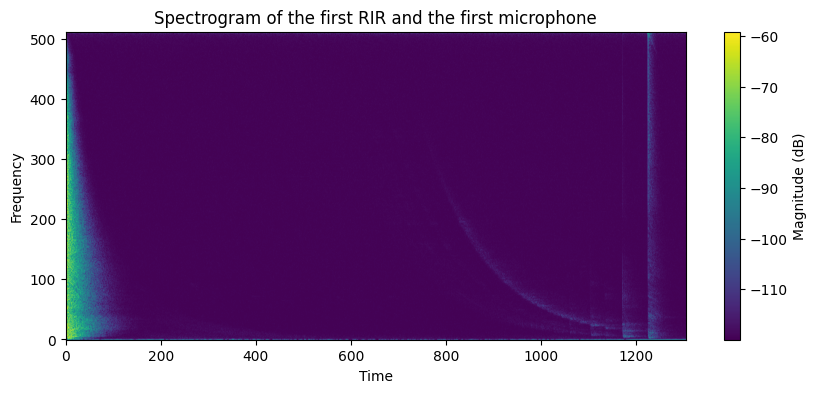

In [10]:
import cupy as cp
from cupyx.scipy import signal as csignal
import numpy as np
import matplotlib.pyplot as plt

# Load the deconvolved RIRs

# Parameters for spectrogram computation
nfft = 1024  # FFT size
hop_length = 512  # Hop length for STFT
fs = 44100  # Sample rate, adjust according to your data if different

# Compute the spectrogram for each RIR
spectrograms = []
for rir in rir_data:
    spectrogram_mic = []
    for mic_rir in rir:
        # Compute the short-time Fourier transform (STFT) using CUDA
        f, t, Sxx = csignal.stft(cp.asarray(mic_rir), fs, nperseg=nfft, noverlap=nfft-hop_length)

        # Convert magnitude spectrogram to decibels (dB) using CUDA
        Sxx_db = 20 * cp.log10(cp.abs(Sxx) + 1e-6)  # Adding a small value to avoid log(0)

        # Append the spectrogram to the list
        spectrogram_mic.append(cp.asnumpy(Sxx_db))  # Convert back to NumPy array
    spectrograms.append(spectrogram_mic)

# Convert to numpy array
spectrograms = np.array(spectrograms)

# Plot the spectrogram of the first RIR and the first microphone
plt.figure(figsize=(10, 4))
plt.imshow(spectrograms[0][0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram of the first RIR and the first microphone')
plt.show()


In [11]:

import torch
from torchvggish import vggish, vggish_input

ModuleNotFoundError: No module named 'torchvggish'

In [ ]:
model = vggish.VGGish(urls=vggish_model_urls)
model.eval()

VGGish(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [ ]:
# Function to preprocess spectrogram data for VGGish
def preprocess_spectrogram_vggish(spectrogram):
    # Resize spectrogram to match VGGish input shape
    spectrogram_resized = cp.resize(spectrogram, (96, 64))  # Assuming VGGish input shape is (96, 64)
    return spectrogram_resized

# Function to extract VGGish features
def extract_vggish_features(spectrogram):
    # Preprocess spectrogram
    spectrogram_resized = preprocess_spectrogram_vggish(spectrogram)
    # Convert to PyTorch tensor
    spectrogram_tensor = torch.from_numpy(cp.asnumpy(spectrogram_resized)).float().unsqueeze(0)  # Add batch dimension
    # Forward pass through VGGish model
    with torch.no_grad():
        features = model(spectrogram_tensor)
    return features.numpy().flatten()  # Convert to numpy array

# Assuming spectrograms contain your preprocessed RIR spectrograms computed using CUDA
# You can iterate over the spectrograms to extract VGGish features
vggish_features = []
for spectrogram_mic in spectrograms:
    for spectrogram in spectrogram_mic:
        features = extract_vggish_features(spectrogram)
        vggish_features.append(features)

vggish_features = np.array(vggish_features)

NameError: name 'spectrograms' is not defined

In [2]:
spectrograms

NameError: name 'spectrograms' is not defined